In [2]:
from pynq import Overlay

ol = Overlay('/home/xilinx/pynq/overlays/pynq_tremorv4.1/p1p2y3.bit')

In [3]:
dma_0 = ol.axi_dma_0
dma_0_send = ol.axi_dma_0.sendchannel
dma_0_recv = ol.axi_dma_0.recvchannel

In [4]:
#Python algorithm
import math
import numpy as np
from scipy.signal import butter, buttord, filtfilt, firwin, hilbert, lfilter, tf2sos
import matplotlib.pyplot as plt
import time
def tremor_prediction_py(EMG, Fs, prediction_win, weighted_mean_on):
    burst_index = []
    time_for_next_bursts = []
    time_for_next_bursts  = np.array(time_for_next_bursts).astype('uint16')
    mean_ibi = 1
    
    start_time = time.time()
    # Esta parte rectifica y normaliza la señal EMG, y luego la concatena con ceros para evitar problemas en los bordes
    # durante el procesamiento
    EMG = np.abs(EMG) / np.mean(np.abs(EMG))

    zp = 256
    EMG = np.concatenate([np.zeros(zp), EMG, np.zeros(zp)])
    # Calcula un valor (N) basado en la longitud de la señal EMG para su uso posterior en el procesamiento de la señal.
    N = math.floor(len(EMG) / 2.5)

    # Establece los parámetros para un filtro Butterworth según las frecuencias de paso (wp), frecuencias de rechazo
    # (ws) y atenuaciones mínimas en la banda de paso (rp) y en la banda de rechazo (rs)
    wp = np.array([3, 15]) / (Fs / 2)  # Frecuencias de paso normalizadas
    ws = np.array([1, 20]) / (Fs / 2)  # Frecuencias de rechazo normalizadas
    rp = 5  # Atenuación mínima en la banda de paso
    rs = 10  # Atenuación mínima en la banda de rechazo
    n, Wn = buttord(wp, ws, rp, rs)

    # Diseña el filtro Butterworth utilizando los parámetros calculados previamente.
    b2, a2 = butter(n, Wn, btype='bandpass')
    # Calcula los coeficientes para un filtro FIR basado en una ventana plana ("flattop").
    fc = 15  # Frecuencia de corte
    t1 = firwin(N, fc / (Fs), pass_zero="lowpass", window='flattop')
    #Realiza la transformada de Hilbert de la señal EMG y calcula algunas variables relacionadas con esta transformada.
    z = hilbert(EMG) #obtiene la envolvente de amplitud de la señal
    z = np.array(z,np.complex64)

    x = np.abs(z) #obtiene la magnitud de la envolvente

    y = np.angle(z) #obtiene la fase de la señal

    p = lfilter(t1, 1, np.concatenate([y, np.zeros(N // 2)])) 
    p=np.array(p, dtype = np.float32)#aplica el filtro FIR t1 creado anteriormente a la
    #fase de la señal. El filtro se aplica a la señal concatenada con ceros para asegurar que no haya problemas en los
    # bordes durante la convolución.
    p = p[N // 2:] #Recorta los primeros N // 2 elementos de la señal filtrada. Esto se hace para eliminar las muestras
    # de cero agregadas para el relleno y obtener el resultado relevante del filtrado.
    
    a = lfilter(t1, 1, np.concatenate([x, np.zeros(N // 2)])) 
    a=np.array(a, dtype = np.float32)#aplica el filtro FIR t1 creado anteriormente a la
    #magnitud de la señal. El filtro se aplica a la señal concatenada con ceros para asegurar que no haya problemas en
    # los bordes durante la convolución.
    a = a[N // 2:] #Recorta los primeros N // 2 elementos de la señal filtrada. Esto se hace para eliminar las muestras
    # de cero agregadas para el relleno y obtener el resultado relevante del filtrado.
    iht_component = np.cos(p) * a # Calcula un componente específico de la transformada de Hilbert. p es la fase
    # filtrada de la señal EMG y a es la envolvente de amplitud filtrada. Al multiplicar la señal de fase por el
    # coseno de esta señal, se está generando un componente específico de la transformada de Hilbert. Esto se hace
    # para enfocarse en ciertas características de la señal que pueden estar asociadas con los temblores.
    tremor = lfilter(b2, a2, iht_component) #Aplica un filtro Butterworth (b2, a2) al componente específico de la
    # transformada de Hilbert (iht_component). Esto se realiza para resaltar o aislar aún más ciertas frecuencias o
    # características de interés en la señal.
    tremor = np.array(tremor, dtype = np.float32)

    tremor = tremor[zp:-zp] # Recorta la señal de temblor (tremor) para eliminar muestras agregadas durante el proceso
    # de filtrado. zp se utilizó previamente como una longitud de ceros añadidos al principio y al final de la señal
    # para evitar problemas de borde. Esta operación elimina esos ceros adicionales, dejando solo la señal filtrada
    # relevante de temblor.

    
    # La siguiente parte del código que pertenece a la función "tremor_prediction" está destinada a identificar patrones
    # en la señal de temblores, calcular duraciones, estimar tiempos para futuros temblores y evaluar la duración 
    # relativa de los temblores detectados en relación con la duración media inter-burst.
    thr = 0.25
    tremor_amp = np.sqrt(np.mean(tremor ** 2))
    
    if tremor_amp < thr:
        time_for_next_bursts = 0
        # implica que no se ha detectado tremor
    else:
        burst_cnt = 0
        ibi = []
        # El bucle for recorre la señal de temblor tremor y busca patrones específicos que puedan indicar la presencia
        # de un temblor.
        for t in range(1, len(tremor) - 1):
            # Se calcula la duración de los temblores, la cantidad de temblores, y se estiman los tiempos para los
            # próximos temblores basados en patrones observados en la señal.
            if tremor[t - 1] <= tremor[t] and tremor[t] > tremor[t + 1] and tremor[t] > np.max(tremor) * 0.05:
                burst_cnt += 1
                burst_index.append(t)
                if burst_cnt > 1: #IMPORTANTE: ibi = burst_cnt - 1
                    ibi.append(burst_index[burst_cnt - 1] - burst_index[burst_cnt - 2])
        if weighted_mean_on == 0:
            mean_ibi = np.median(ibi)
        else:
            weight = np.linspace(1, 1 + burst_cnt / 2, burst_cnt)
            mean_ibi = np.sum(weight[:len(ibi)] * ibi) / np.sum(weight[:len(ibi)])
        # PREDICTION OF NEXT BURSTS
        proc_time = 0  # processing time of this algorithm
        flag = 2

        cnt = 0
        time_for_next_bursts = [0]
        while time_for_next_bursts[0] <= len(tremor) + proc_time:
            prediction_temp = np.zeros(burst_cnt)
            cnt += 1
            for t in range(burst_cnt):
                prediction_temp[t] = burst_index[t] + mean_ibi * (burst_cnt - t + cnt)
            prediction_temp = np.array(prediction_temp, dtype = np.float32)
           

            if weighted_mean_on == 0:
                time_for_next_bursts[0] = np.round(np.median(prediction_temp))
            else:
                time_for_next_bursts[0] = np.round(np.sum(weight * prediction_temp) / np.sum(weight))
        cnt = 1

        #Se calcula la duración relativa de los temblores comparando las duraciones de los temblores detectados con la
        # duración media inter-burst (mean_ibi).
        while time_for_next_bursts[cnt - 1] + mean_ibi < len(tremor) + prediction_win:
            time_for_next_bursts = np.append(time_for_next_bursts, np.round(time_for_next_bursts[0] + mean_ibi * cnt))
            cnt += 1
    stop_time = time.time()
    sw_time = stop_time - start_time
    return time_for_next_bursts, tremor, sw_time

In [5]:
#RTL Hardware implementation
import time
from pynq import allocate
def tremor_prediction_rtl(dma_0_send, dma_0_recv,input_array):
    predict_tremor = []
    input_buffer = allocate(shape=(data_size,),dtype=np.uint16)
    output_buffer = allocate(shape=(int(data_size/2)+1,),dtype=np.uint16)
    input_buffer[:] = input_array
    
    #Triggers the DMA transfer and wait for the result
    start_time = time.time()
    dma_0_send.transfer(input_buffer)
    dma_0_recv.transfer(output_buffer)
    dma_0_send.wait()
    dma_0_recv.wait()
    stop_time = time.time()
    hw_time = stop_time-start_time
    
    if (output_buffer[0] == 0):
        predict_tremor.append(output_buffer[0])
    else:
        for j in range (len(output_buffer)):
            if (output_buffer[j] == 0):
                break
            else:
                predict_tremor.append(output_buffer[j])
    #Free the buffers
    input_buffer.flush()
    input_buffer.freebuffer()
    input_buffer.close()
    output_buffer.flush()
    output_buffer.freebuffer()
    output_buffer.close()
    
    return predict_tremor, hw_time

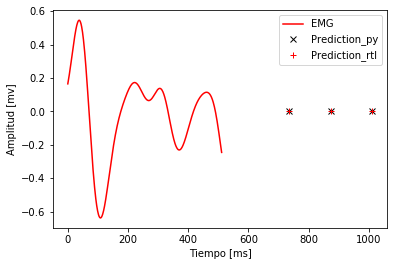

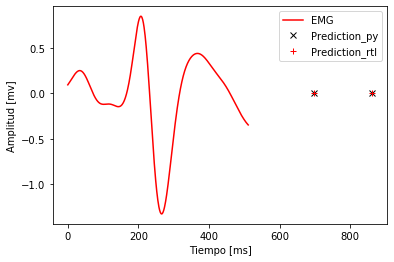

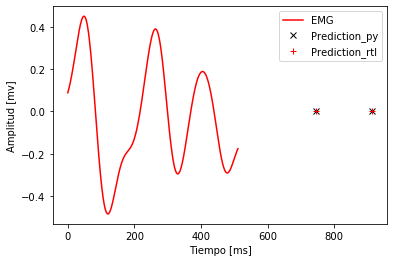

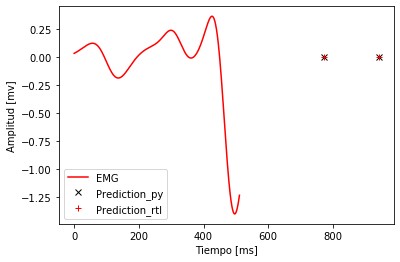

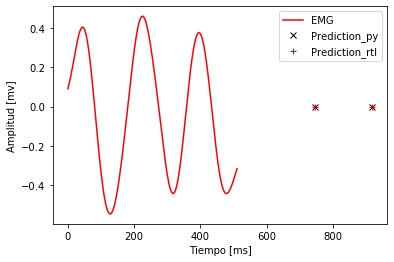

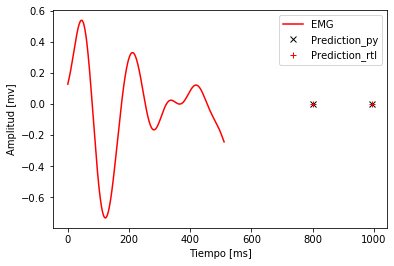

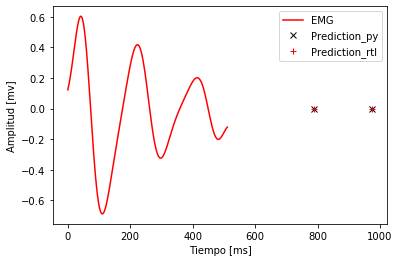

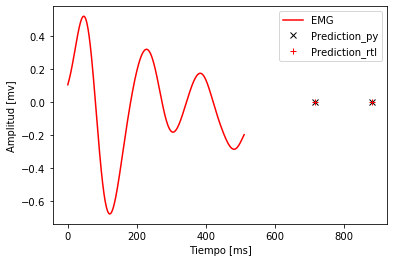

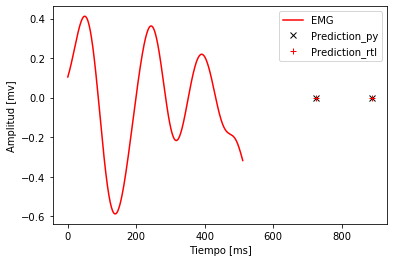

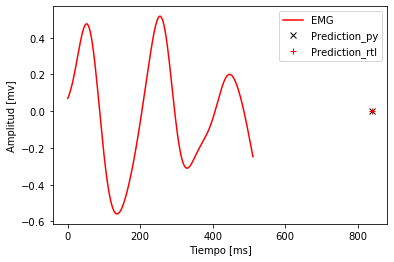

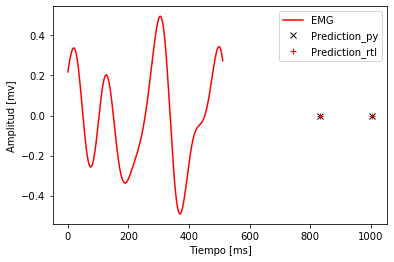

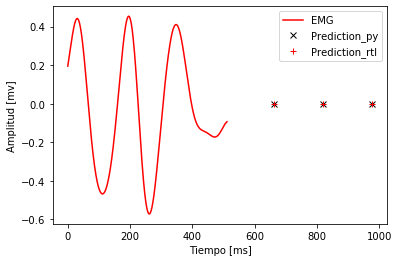

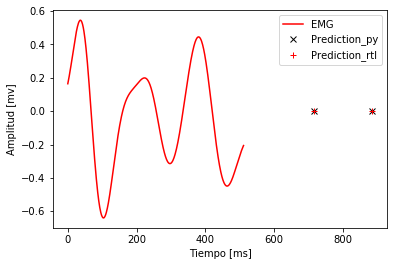

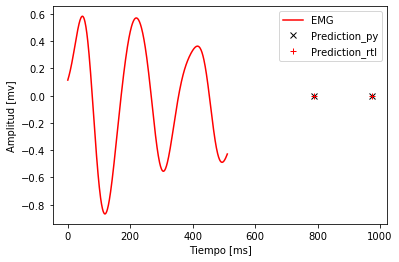

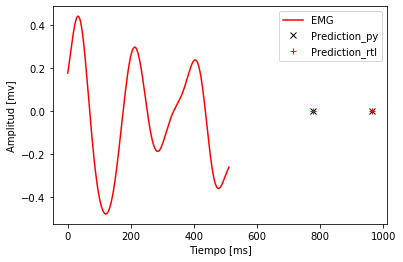

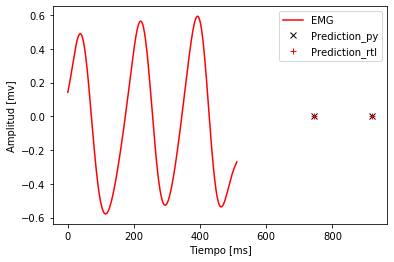

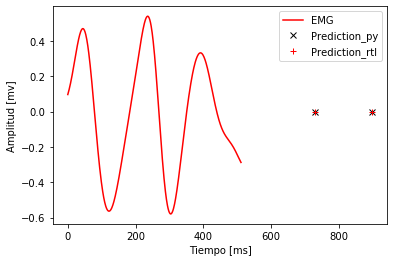

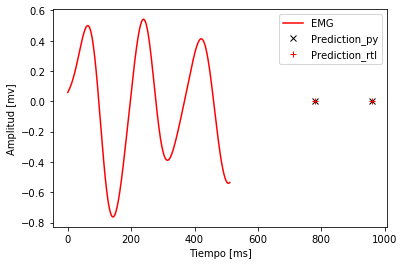

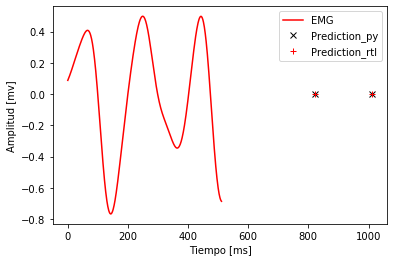

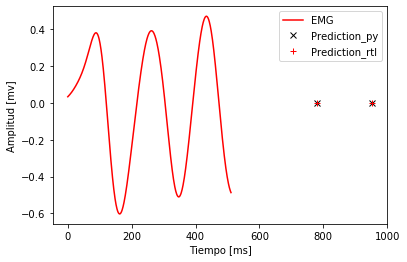

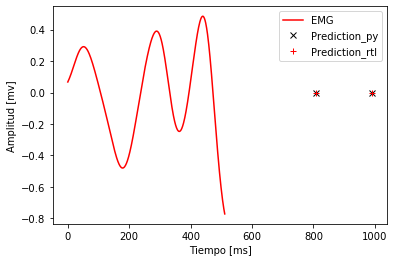

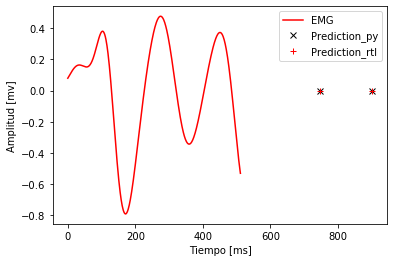

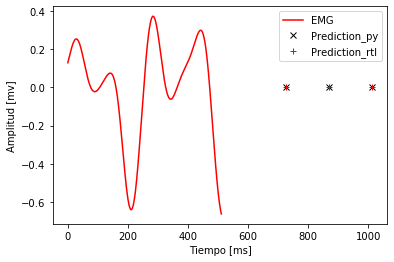

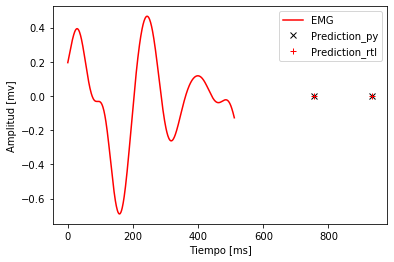

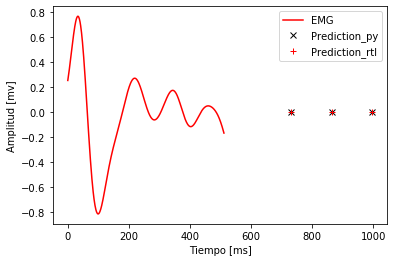

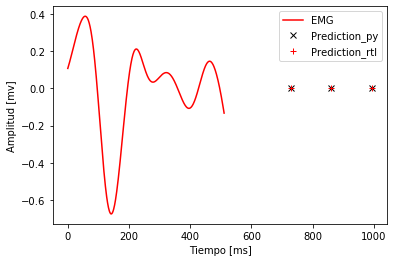

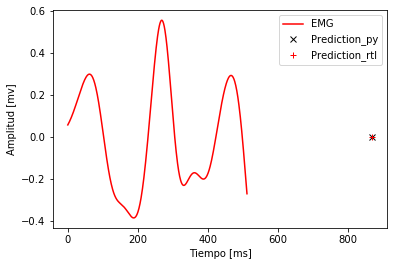

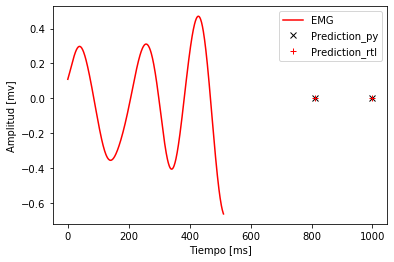

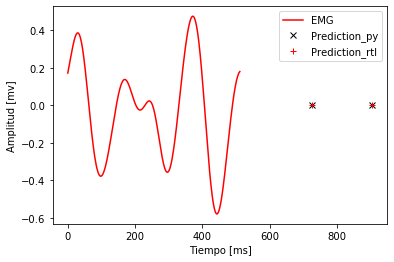

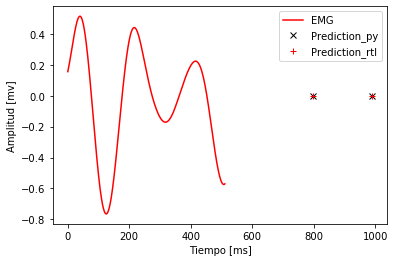

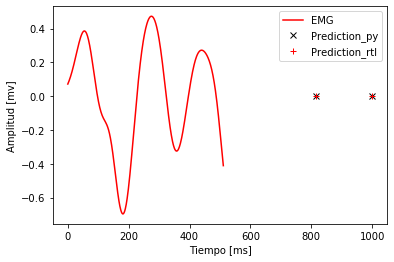

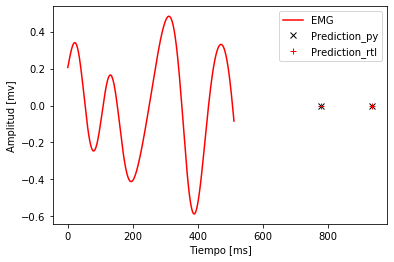

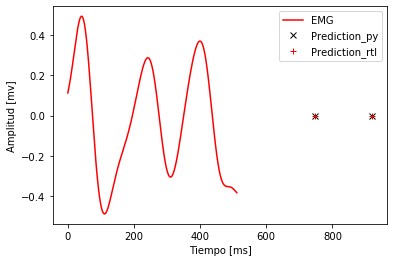

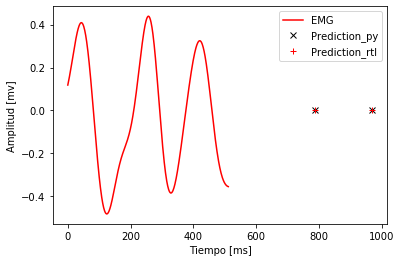

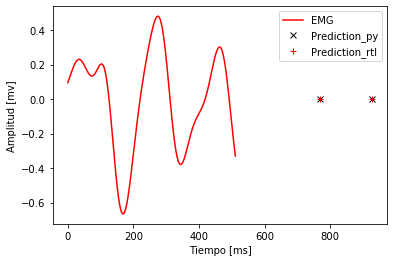

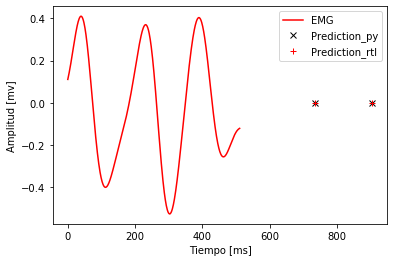

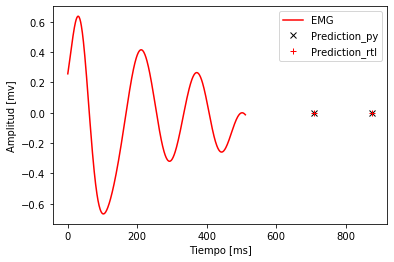

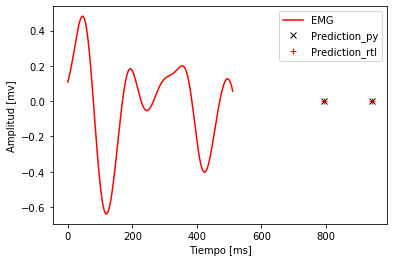

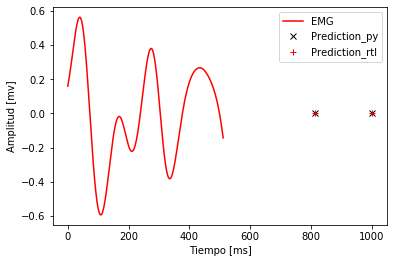

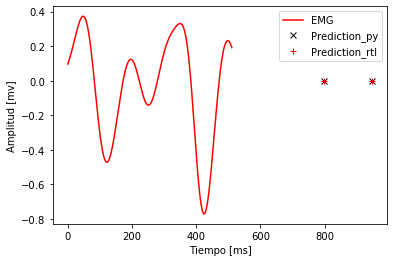

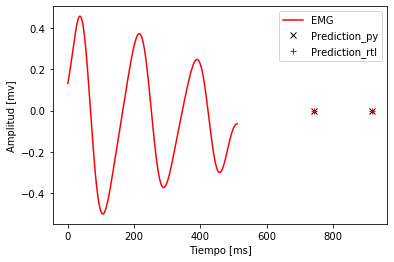

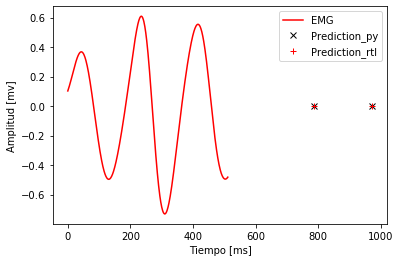

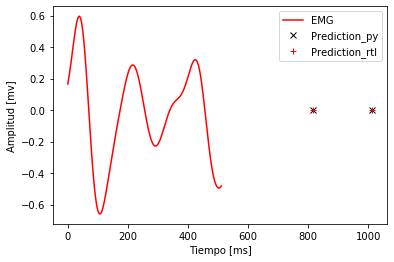

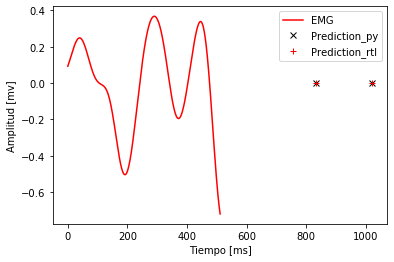

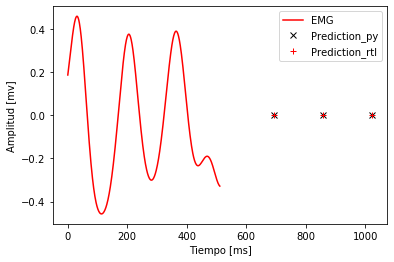

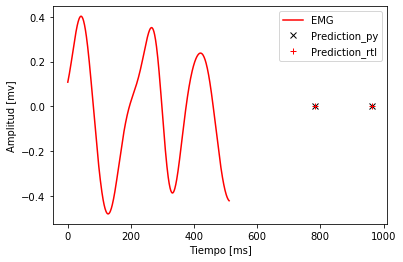

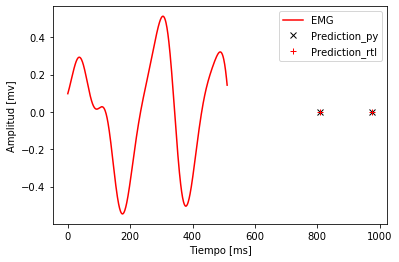

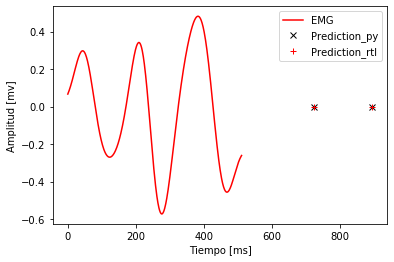

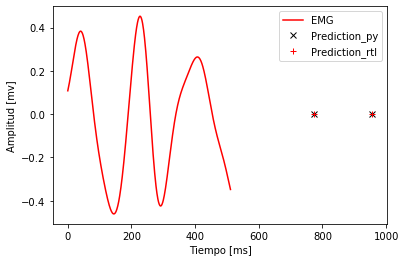

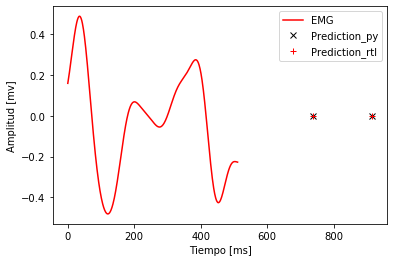

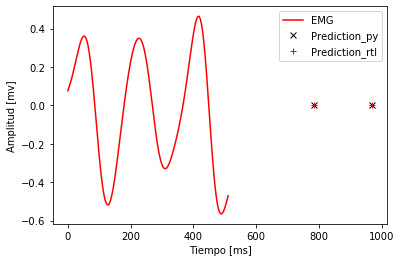

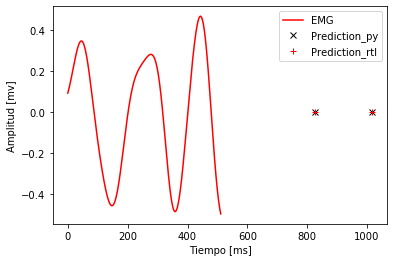

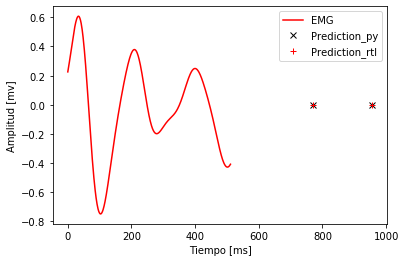

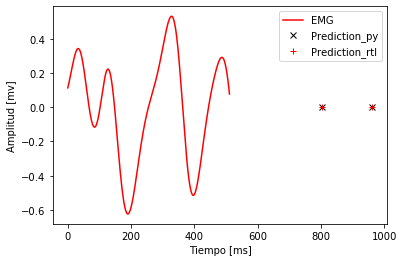

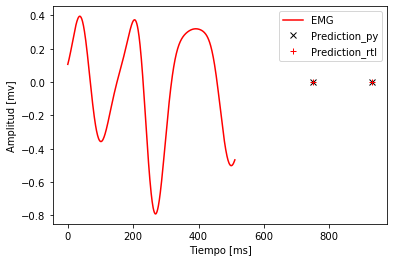

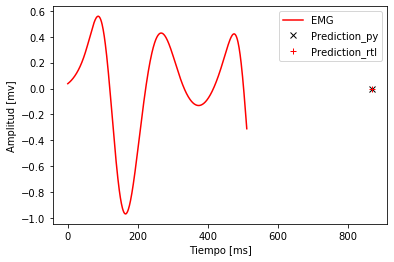

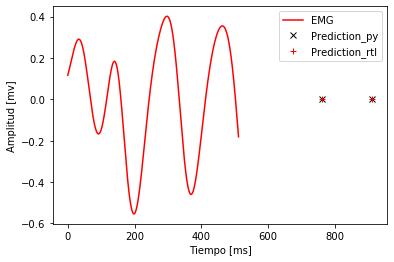

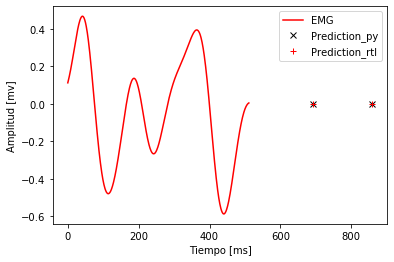

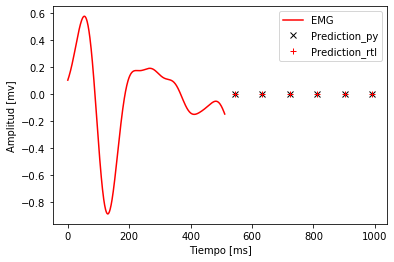

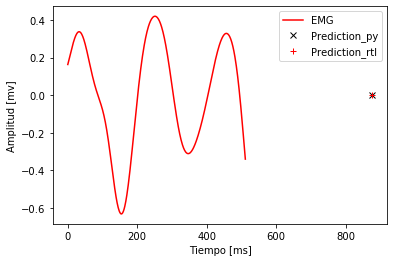

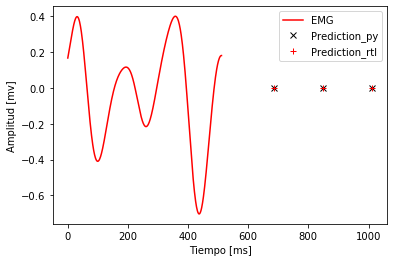

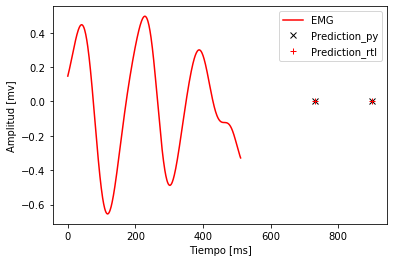

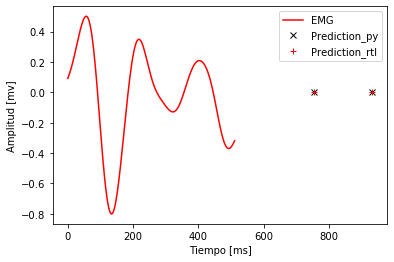

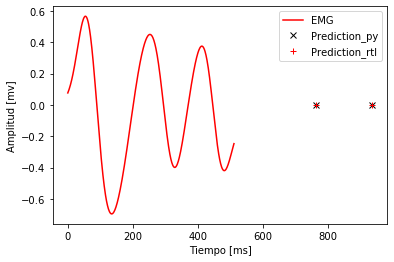

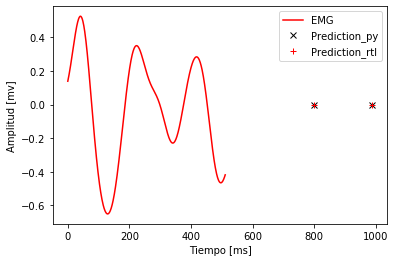

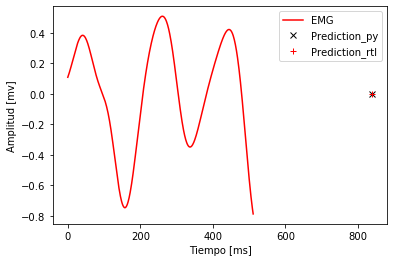

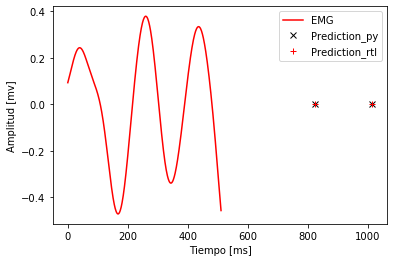

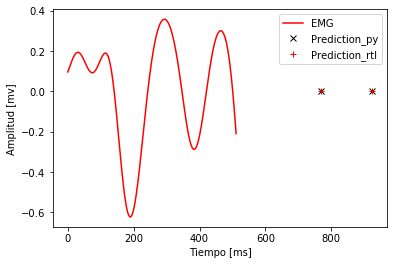

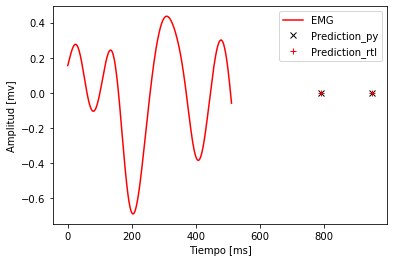

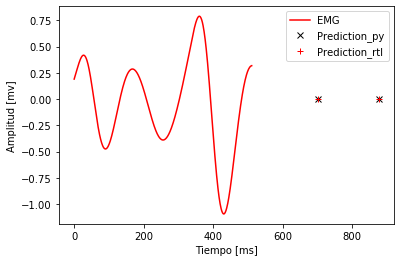

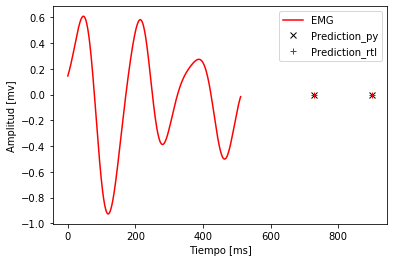

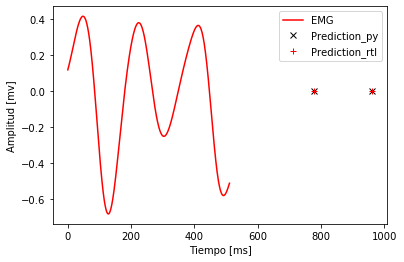

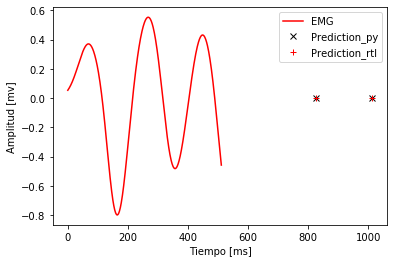

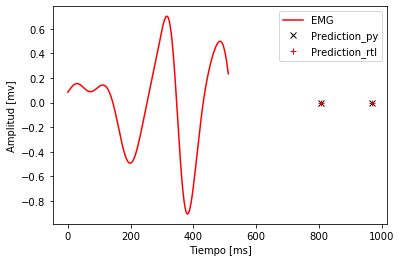

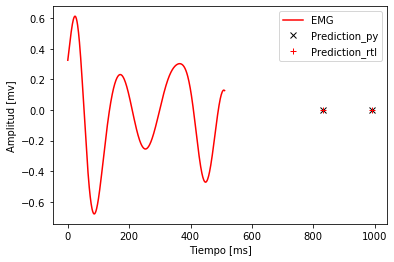

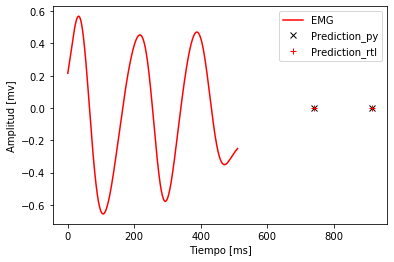

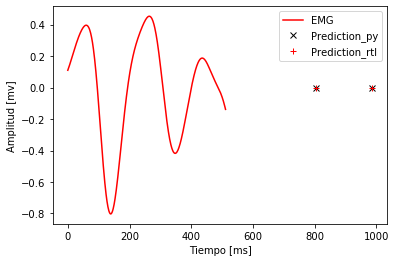

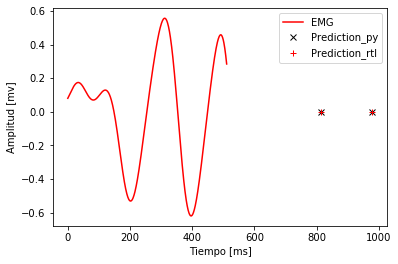

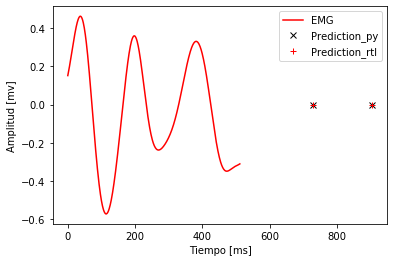

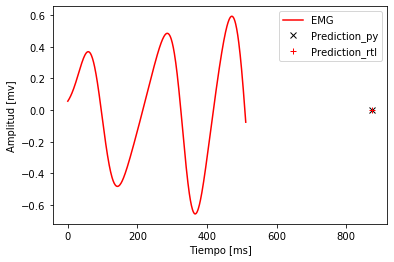

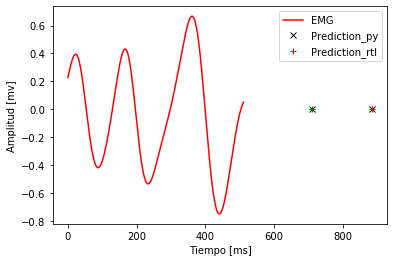

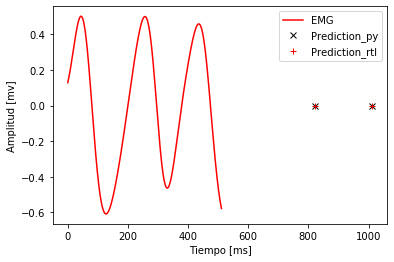

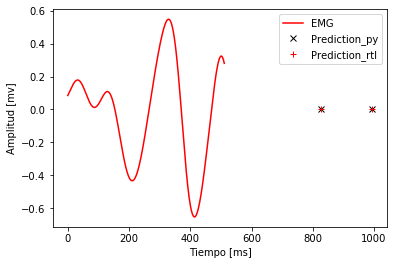

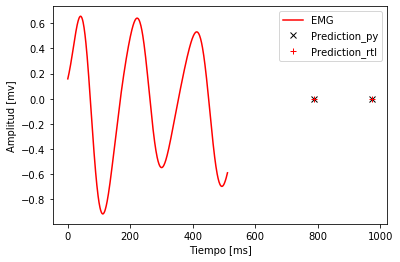

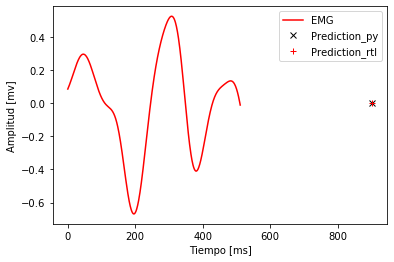

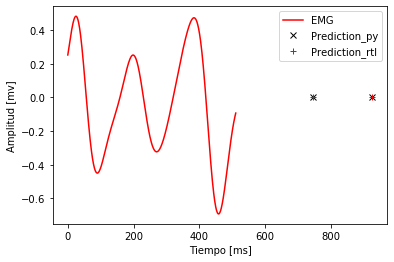

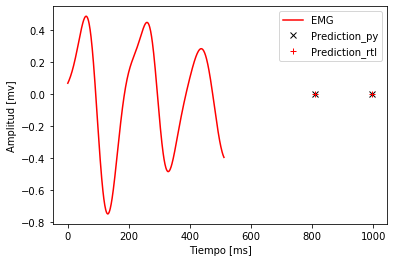

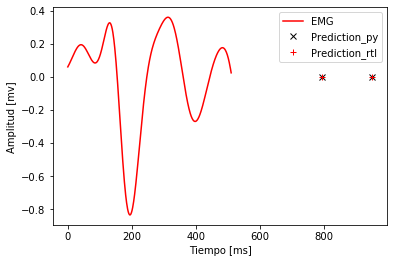

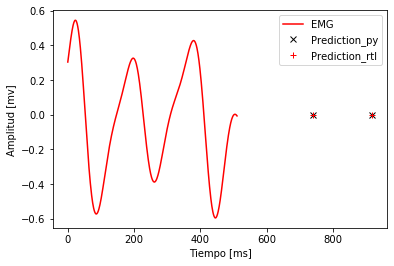

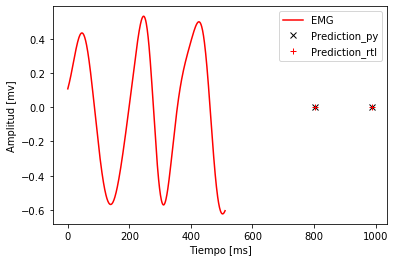

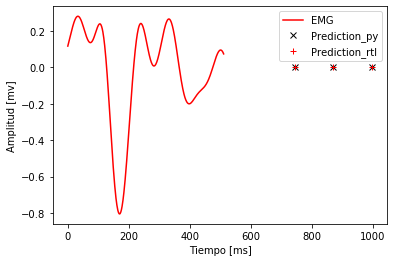

In [6]:
import math
import numpy as np
from scipy.signal import butter, buttord, filtfilt, firwin, hilbert, lfilter, tf2sos
import matplotlib.pyplot as plt
from opensignalsreader import OpenSignalsReader
from operator import length_hint
import time
from pynq import allocate





#tremor_prediction_py specifications
Fs = 1000  # Frecuencia de muestreo
pred_window = 0.512  # Ventana de predicción en segundos
pw = int(Fs * pred_window)  # Ventana de predicción en muestras
acq = OpenSignalsReader("/home/xilinx/pynq/overlays/paciente_1_configuracion_5_py.txt")
var1 = acq.raw('EMG')
var2 = acq.signal('EMG')
var3 = np.array(var2,dtype=np.float32)
var_rtl = acq.raw('EMG')
input_array = []
input_array = np.array(var_rtl,dtype=np.uint16)
data_size = 512
total_windows = int(len(input_array)/data_size)
sw_exec_time_array = []
hw_exec_time_array = []
for i in range(total_windows):
    [pred_py, temp_py, sw_exec_time] = tremor_prediction_py(var3[data_size*i: data_size*(i+1)], Fs, pw, 1)
    [pred_rtl, hw_exec_time] = tremor_prediction_rtl(dma_0_send, dma_0_recv, input_array[data_size*i: data_size*(i+1)])
    sw_exec_time_array.append(sw_exec_time)
    hw_exec_time_array.append(hw_exec_time)
    if ( length_hint(pred_py) > 0 and length_hint(pred_rtl) > 0):  # si se predice un temblor
        plt.plot(temp_py, 'r', label='EMG')
        plt.plot(pred_py, np.zeros(len(pred_py)), 'kx', label='Prediction_py')
        plt.plot(pred_rtl, np.zeros(len(pred_rtl)), 'r+', label='Prediction_rtl')
        plt.xlabel('Tiempo [ms]')
        plt.ylabel('Amplitud [mv]')
        plt.legend()
        plt.show()



In [7]:
import math

average_sw_exec_time = np.mean(sw_exec_time_array)
average_hw_exec_time = np.mean(hw_exec_time_array)

print("SOFTWARE average execution time: ", average_sw_exec_time)
print("SOFTWARE total execution time: ", np.sum(sw_exec_time_array))
print("\n")
print("HARDWARE average execution time: ", average_hw_exec_time)
print("HARDWARE total execution time: ", np.sum(hw_exec_time_array))
print("\n")
print("HARDWARE acceleration factor: ", average_sw_exec_time/average_hw_exec_time)
sw_exec_time_array = []
hw_exec_time_array = []


SOFTWARE average execution time:  0.02661788341950397
SOFTWARE total execution time:  5.217105150222778


HARDWARE average execution time:  0.014235664387138523
HARDWARE total execution time:  2.7901902198791504


HARDWARE acceleration factor:  1.8698026797788514
